In [1]:
!pip install torch --quiet

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# !unzip drive/MyDrive/celeba.zip
# !unzip /content/celeba/img_align_celeba.zip

In [18]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Data Augmentation

In [20]:
from torchvision import transforms
get_smile = lambda attr: attr[31]

transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [21]:
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

### Loading and Preprocessing Dataset

In [27]:
import torchvision
from torch.utils.data import DataLoader

image_path = './'

celeba_train_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='train',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform_train,
                                                   target_transform=get_smile)

celeba_valid_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='valid',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path,
                                                   split='test',
                                                   target_type='attr',
                                                   download=False,
                                                   transform=transform,
                                                   target_transform=get_smile)

from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


In [28]:
batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

### Training a CNN Smile classifier

In [32]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

In [33]:
device = torch.device("cuda:0")
# device = torch.device("cpu")
model = model.to(device)

### Model Training

In [34]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.5120 val_accuracy: 0.5480
Epoch 2 accuracy: 0.5337 val_accuracy: 0.5750
Epoch 3 accuracy: 0.5536 val_accuracy: 0.5810
Epoch 4 accuracy: 0.5939 val_accuracy: 0.6120
Epoch 5 accuracy: 0.6371 val_accuracy: 0.6280
Epoch 6 accuracy: 0.6491 val_accuracy: 0.6570
Epoch 7 accuracy: 0.6618 val_accuracy: 0.6420
Epoch 8 accuracy: 0.6868 val_accuracy: 0.6730
Epoch 9 accuracy: 0.7131 val_accuracy: 0.7650
Epoch 10 accuracy: 0.7495 val_accuracy: 0.7400
Epoch 11 accuracy: 0.7801 val_accuracy: 0.8080
Epoch 12 accuracy: 0.8056 val_accuracy: 0.8480
Epoch 13 accuracy: 0.8232 val_accuracy: 0.8200
Epoch 14 accuracy: 0.8308 val_accuracy: 0.8600
Epoch 15 accuracy: 0.8442 val_accuracy: 0.8580
Epoch 16 accuracy: 0.8510 val_accuracy: 0.8630
Epoch 17 accuracy: 0.8564 val_accuracy: 0.8690
Epoch 18 accuracy: 0.8656 val_accuracy: 0.8890
Epoch 19 accuracy: 0.8661 val_accuracy: 0.8870
Epoch 20 accuracy: 0.8684 val_accuracy: 0.8900
Epoch 21 accuracy: 0.8706 val_accuracy: 0.9000
Epoch 22 accuracy: 0.8

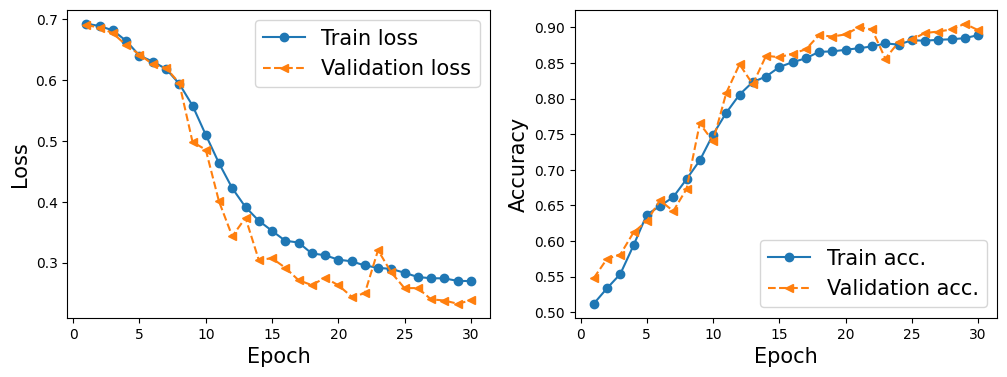

In [36]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [37]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9034


### Prediction Samples

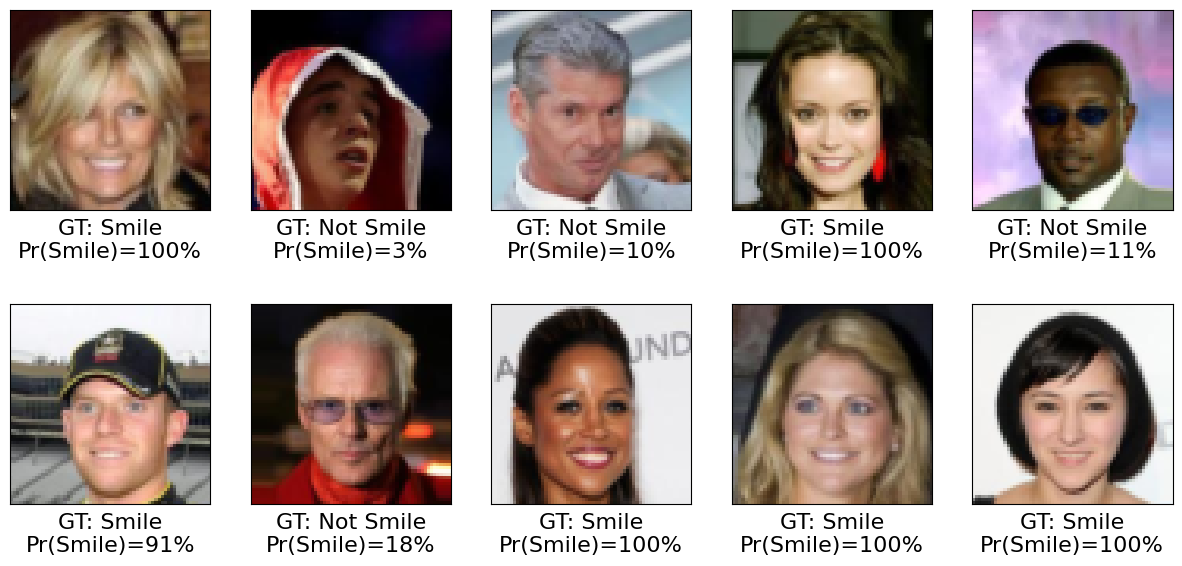

In [38]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    if y_batch[j] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

### Saving the Model

In [39]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'
torch.save(model, path)